<a href="https://colab.research.google.com/github/ekanshlakhyani/DeepLearning/blob/main/Glassdoor_final_prediction_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Load the small and large training datasets
small_train_file = '/content/424_F2024_Final_PC_small_train_v1.csv'
large_train_file = '/content/424_F2024_Final_PC_large_train_v1.csv'
test_file = '/content/424_F2024_Final_PC_test_without_response_v1.csv'

In [4]:
small_train_data = pd.read_csv(small_train_file)
large_train_data = pd.read_csv(large_train_file)
test_data = pd.read_csv(test_file)

In [5]:
# Combine small and large training datasets
train_data = pd.concat([small_train_data, large_train_data], ignore_index=True)
train_data = train_data.sample(frac=0.005, random_state=42)


In [6]:
# Prepare features and target for the combined training data
X_train = train_data.drop(columns='rating')
y_train = train_data['rating']
X_test = test_data

# Convert text columns to strings
text_columns = ['headline', 'pros', 'cons', 'year_review', 'firm']
for col in text_columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Tokenize the text columns
tokenizer = Tokenizer()
tokenizer.fit_on_texts(
    X_train['headline'] + X_train['pros'] + X_train['cons'] +
    X_train['year_review'] + X_train['firm']
)
vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences for each text column
maxlen = 150  # Set maximum length for text inputs
X_train_headline_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_train['headline']), maxlen=maxlen)
X_train_pros_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_train['pros']), maxlen=maxlen)
X_train_cons_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_train['cons']), maxlen=maxlen)
X_train_year_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_train['year_review']), maxlen=1)
X_train_firm_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_train['firm']), maxlen=1)

X_test_headline_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_test['headline']), maxlen=maxlen)
X_test_pros_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_test['pros']), maxlen=maxlen)
X_test_cons_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_test['cons']), maxlen=maxlen)
X_test_year_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_test['year_review']), maxlen=1)
X_test_firm_pad = pad_sequences(
    tokenizer.texts_to_sequences(X_test['firm']), maxlen=1)

# Define the inputs
headline_input = Input(shape=(maxlen,))
pros_input = Input(shape=(maxlen,))
cons_input = Input(shape=(maxlen,))
year_input = Input(shape=(1,))
firm_input = Input(shape=(1,))


In [7]:
# Embedding Layers
embedding_dim = 50
headline_embedding = Embedding(
    vocab_size, embedding_dim, input_length=maxlen)(headline_input)
pros_embedding = Embedding(vocab_size, embedding_dim,
                           input_length=maxlen)(pros_input)
cons_embedding = Embedding(vocab_size, embedding_dim,
                           input_length=maxlen)(cons_input)
year_embedding = Embedding(vocab_size, 8, input_length=1)(year_input)
firm_embedding = Embedding(vocab_size, 8, input_length=1)(firm_input)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
# LSTM Layers for headline, pros, and cons
headline_lstm = Bidirectional(LSTM(64))(Dropout(0.2)(headline_embedding))
pros_lstm = Bidirectional(LSTM(64))(Dropout(0.2)(pros_embedding))
cons_lstm = Bidirectional(LSTM(64))(Dropout(0.2)(cons_embedding))
from tensorflow.keras.layers import Flatten
# Flatten embeddings for year and firm
year_flatten = Flatten()(Dropout(0.2)(year_embedding))
firm_flatten = Flatten()(Dropout(0.2)(firm_embedding))

In [9]:
# Combine all features
merged = Concatenate()(
    [headline_lstm, pros_lstm, cons_lstm, year_flatten, firm_flatten])

# Dense layers
dense_1 = Dense(64, activation='relu')(Dropout(0.2)(merged))
output = Dense(1, activation='linear')(dense_1)

from tensorflow.keras.models import Model # Import the Model class
# Build the model
model = Model(inputs=[headline_input, pros_input,
              cons_input, year_input, firm_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Print model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 150, 50)        │        734,250 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 150, 50)        │        734,250 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 150, 50)        │        734,250 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 8)           │        117,480 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 8)           │        117,480 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 150, 50)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 150, 50)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 150, 50)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 1, 8)           │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1, 8)           │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         58,880 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128)            │         58,880 │ dropout_1[0][0]        │
│ (Bidirectional)      

 Total params: 2,640,079 (10.07 MB)

 Trainable params: 2,640,079 (10.07 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    [X_train_headline_pad, X_train_pros_pad,
        X_train_cons_pad, X_train_year_pad, X_train_firm_pad],
    y_train,
    epochs=12,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 748ms/step - loss: 6.2551 - mse: 6.2551 - val_loss: 1.2456 - val_mse: 1.2456
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 712ms/step - loss: 1.2001 - mse: 1.2001 - val_loss: 1.1016 - val_mse: 1.1016
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 661ms/step - loss: 1.0084 - mse: 1.0084 - val_loss: 0.9104 - val_mse: 0.9104
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 720ms/step - loss: 0.7070 - mse: 0.7070 - val_loss: 0.7727 - val_mse: 0.7727
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 730ms/step - loss: 0.4673 - mse: 0.4673 - val_loss: 0.7834 - val_mse: 0.7834
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 724ms/step - loss: 0.3213 - mse: 0.3213 - val_loss: 0.8268 - val_mse: 0.8268
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 692ms/step - loss: 0.2242 - mse: 0.2242 - val_loss: 0.8474 - val_mse: 0.8474


In [20]:
# Predict the ratings for the test set
predictions = model.predict(
    [X_test_headline_pad, X_test_pros_pad,
        X_test_cons_pad, X_test_year_pad, X_test_firm_pad]
)

# Save predictions to CSV
output_file = 'predicted_ratings_only.csv'
pd.DataFrame(predictions, columns=['predicted_ratings']).to_csv(
    output_file, index=False)
print("Predicted ratings saved to:", output_file)

  54/3125 ━━━━━━━━━━━━━━━━━━━━ 6:07 120ms/step

KeyboardInterrupt: 

In [15]:
from sklearn.metrics import r2_score

# ... (your existing code) ...

# After training the model
y_train_pred = model.predict(
    [X_train_headline_pad, X_train_pros_pad,
     X_train_cons_pad, X_train_year_pad, X_train_firm_pad]
)

r2 = r2_score(y_train, y_train_pred)
print(f"R2 in training data: {r2}")

5625/5625 ━━━━━━━━━━━━━━━━━━━━ 659s 117ms/step
R2 in training data: 0.580470621585846


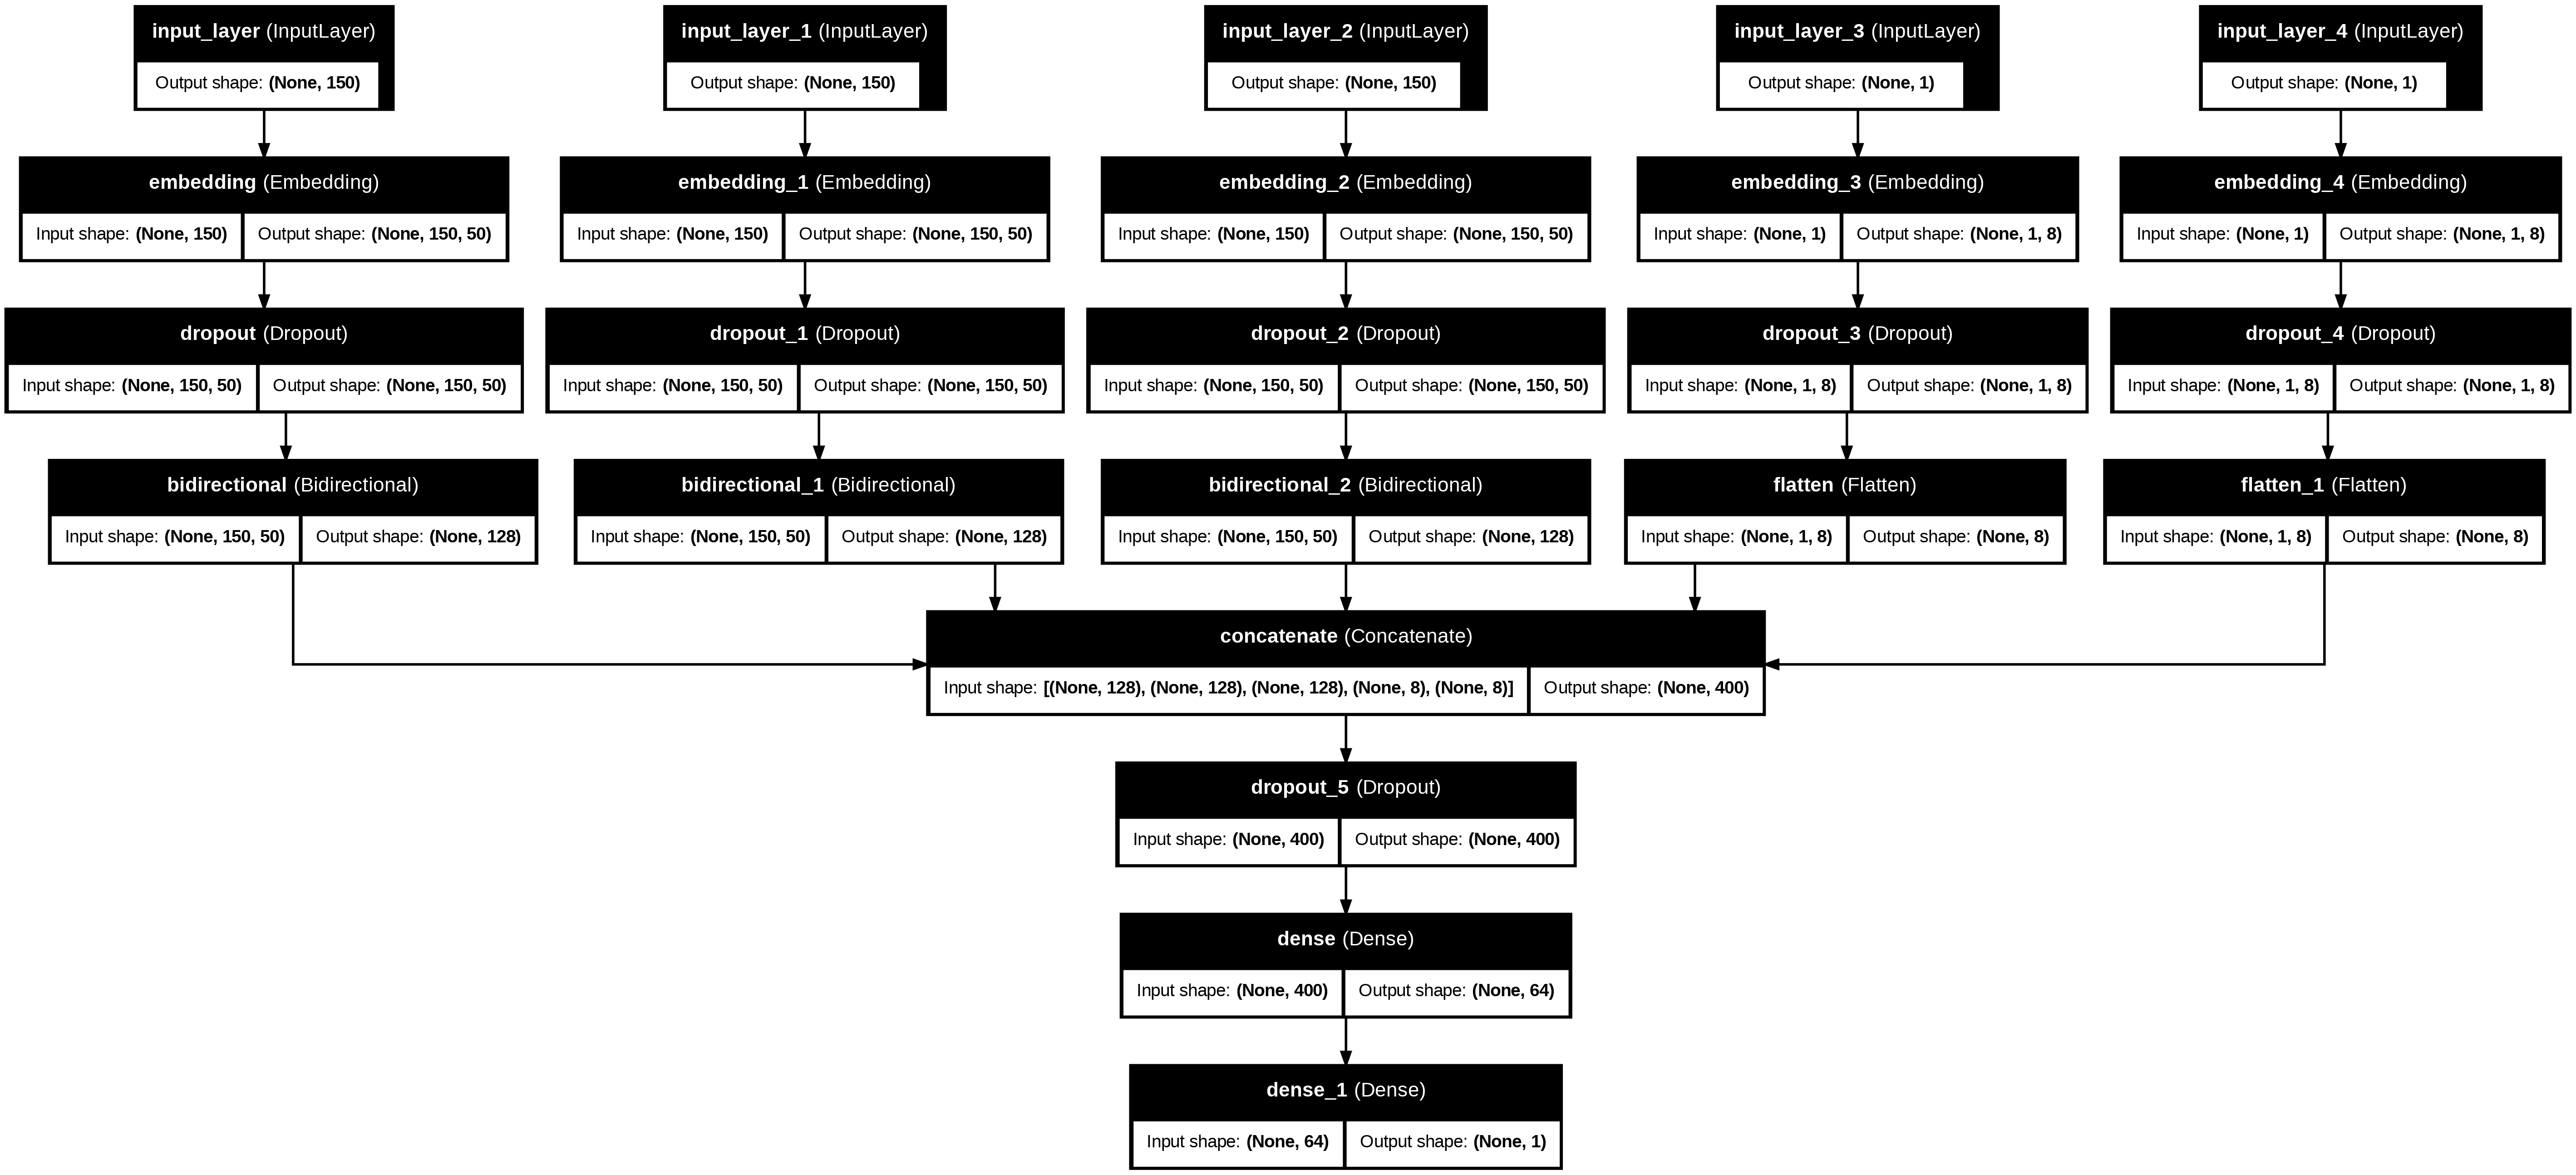

In [17]:
from tensorflow.keras.utils import plot_model

from IPython.display import Image
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
Image('model_structure.png') # Display the image inline in the notebook

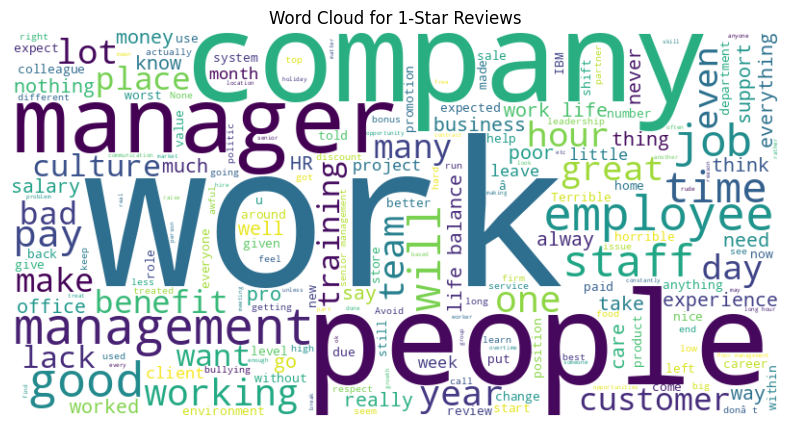

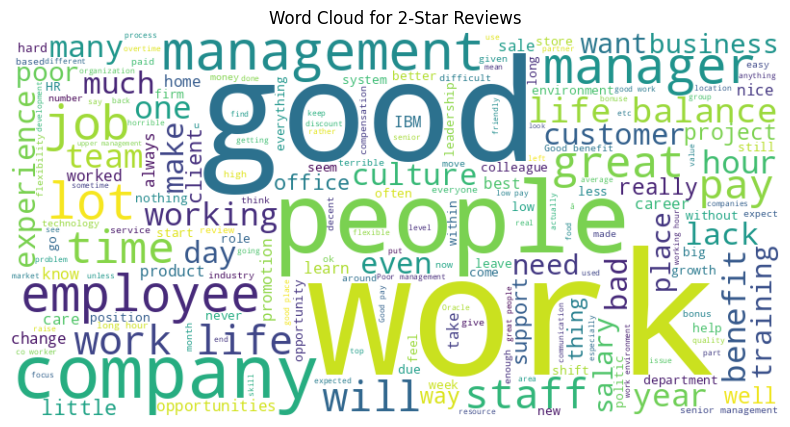

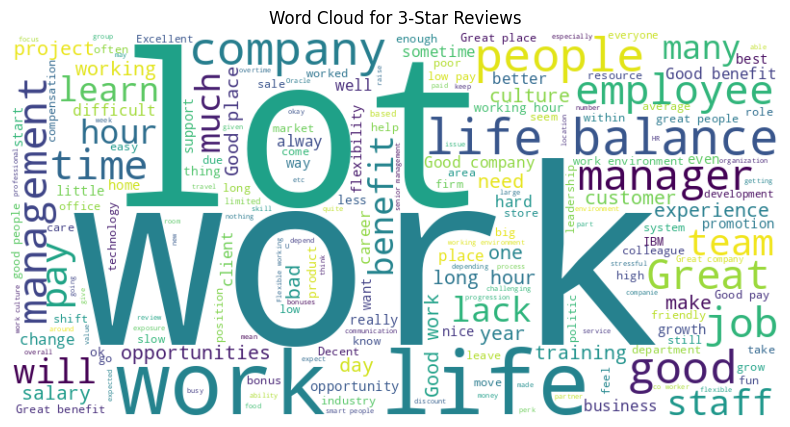

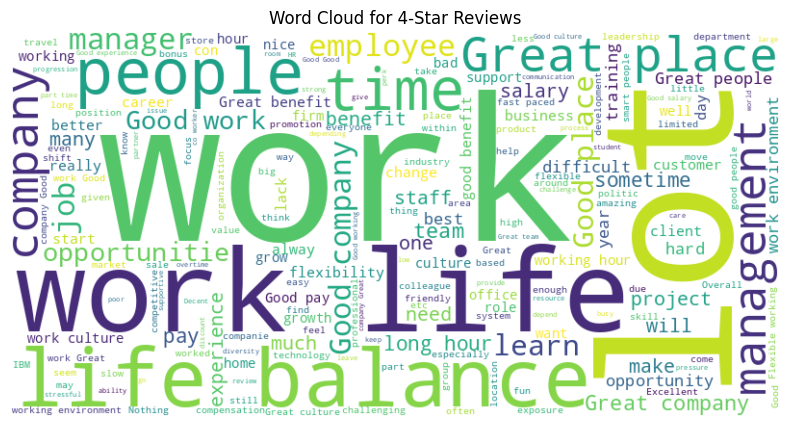

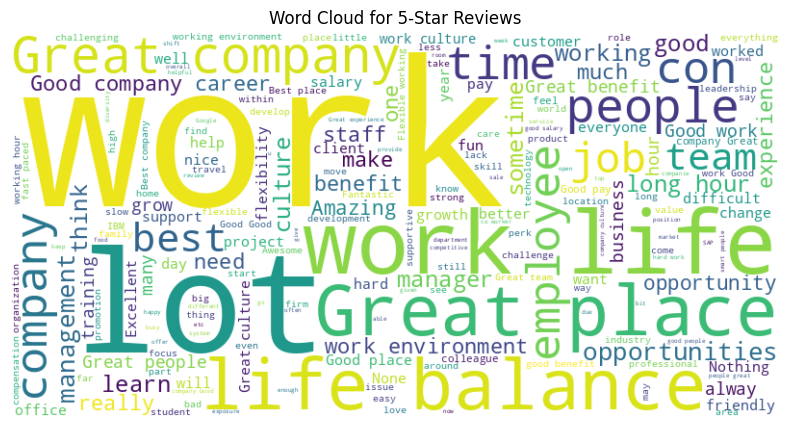

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

for star in range(1, 6):
    reviews = train_data[train_data['rating'] == star]
    text = ' '.join(reviews['headline'].astype(str) + ' ' + reviews['pros'].astype(str) + ' ' + reviews['cons'].astype(str))
    generate_wordcloud(text, f"Word Cloud for {star}-Star Reviews")


In [21]:
!pip install shap


In [22]:
!pip install --upgrade scikit-learn


In [23]:
!pip install eli5

In [11]:
import shap

# Create a DeepExplainer
explainer = shap.DeepExplainer(model, [X_train_headline_pad, X_train_pros_pad, X_train_cons_pad, X_train_year_pad, X_train_firm_pad])


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [12]:
# Calculate SHAP values for a subset of the training data (due to computation constraints)
shap_values = explainer.shap_values([X_train_headline_pad, X_train_pros_pad, X_train_cons_pad, X_train_year_pad, X_train_firm_pad])



AttributeError: 'NoneType' object has no attribute 'numpy'

In [15]:

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from copy import deepcopy


In [16]:
def permutation_importance(model, X_data, y_true, feature_names, n_repeats=5):
    baseline_mse = mean_squared_error(y_true, model.predict(X_data))
    feature_importances = []

    for i, feature_name in enumerate(feature_names):
        mse_diffs = []

        for _ in range(n_repeats):
            # Make a copy of the data and shuffle the current feature
            X_data_permuted = deepcopy(X_data)
            X_data_permuted[i] = np.random.permutation(X_data_permuted[i])

            # Predict with permuted data
            y_pred = model.predict(X_data_permuted)
            mse_permuted = mean_squared_error(y_true, y_pred)

            # Calculate the change in MSE
            mse_diffs.append(mse_permuted - baseline_mse)

        # Average the MSE differences for this feature
        feature_importances.append(np.mean(mse_diffs))

    return feature_importances


In [17]:
# Combine input data into a list format expected by the model
X_train_combined = [X_train_headline_pad, X_train_pros_pad, X_train_cons_pad, X_train_year_pad, X_train_firm_pad]

# Feature names
feature_names = ['Headline', 'Pros', 'Cons', 'Year Review', 'Firm']


In [18]:
importances = permutation_importance(model, X_train_combined, y_train, feature_names)


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 126

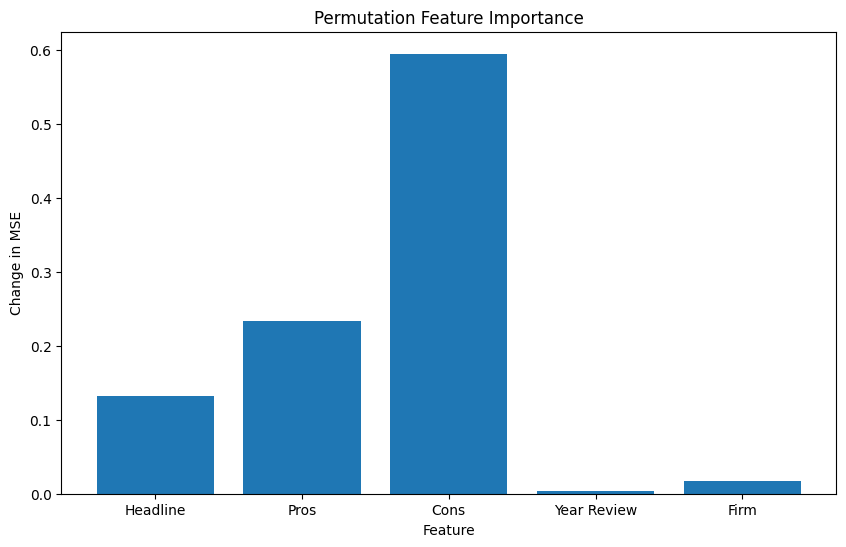

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Permutation Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Change in MSE')
plt.show()


In [20]:
# Convert padded sequences to numerical summaries (e.g., mean of each sequence)
headline_numeric = np.mean(X_train_headline_pad, axis=1)
pros_numeric = np.mean(X_train_pros_pad, axis=1)
cons_numeric = np.mean(X_train_cons_pad, axis=1)
year_numeric = np.mean(X_train_year_pad, axis=1)
firm_numeric = np.mean(X_train_firm_pad, axis=1)

features_df = pd.DataFrame({
    'Headline': headline_numeric,
    'Pros': pros_numeric,
    'Cons': cons_numeric,
    'Year Review': year_numeric,
    'Firm': firm_numeric
})


In [21]:
correlation_matrix = features_df.corr()
print(correlation_matrix)


             Headline      Pros      Cons  Year Review      Firm
Headline     1.000000  0.145360  0.253024     0.041314  0.028079
Pros         0.145360  1.000000  0.381427     0.029333  0.040034
Cons         0.253024  0.381427  1.000000     0.063170  0.024719
Year Review  0.041314  0.029333  0.063170     1.000000 -0.017630
Firm         0.028079  0.040034  0.024719    -0.017630  1.000000


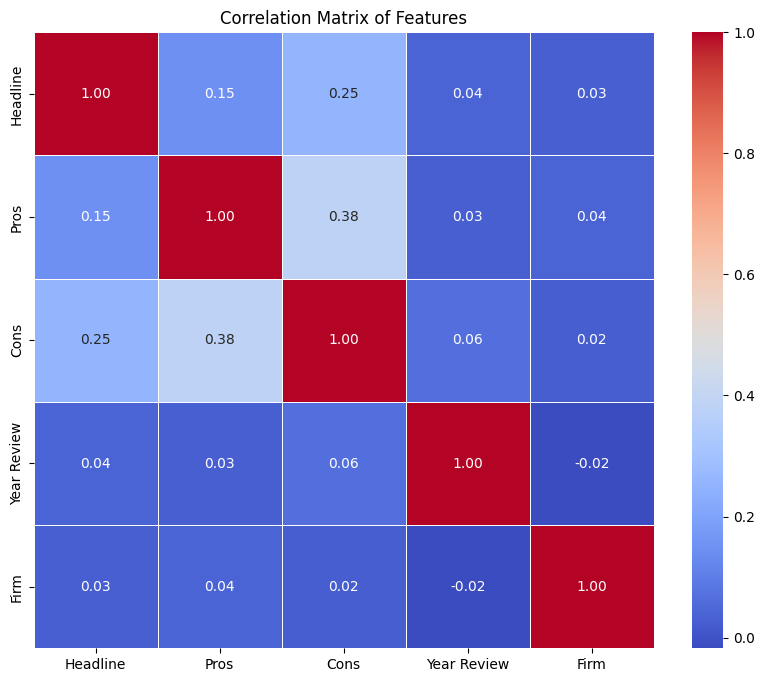

In [22]:

import seaborn as sns

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


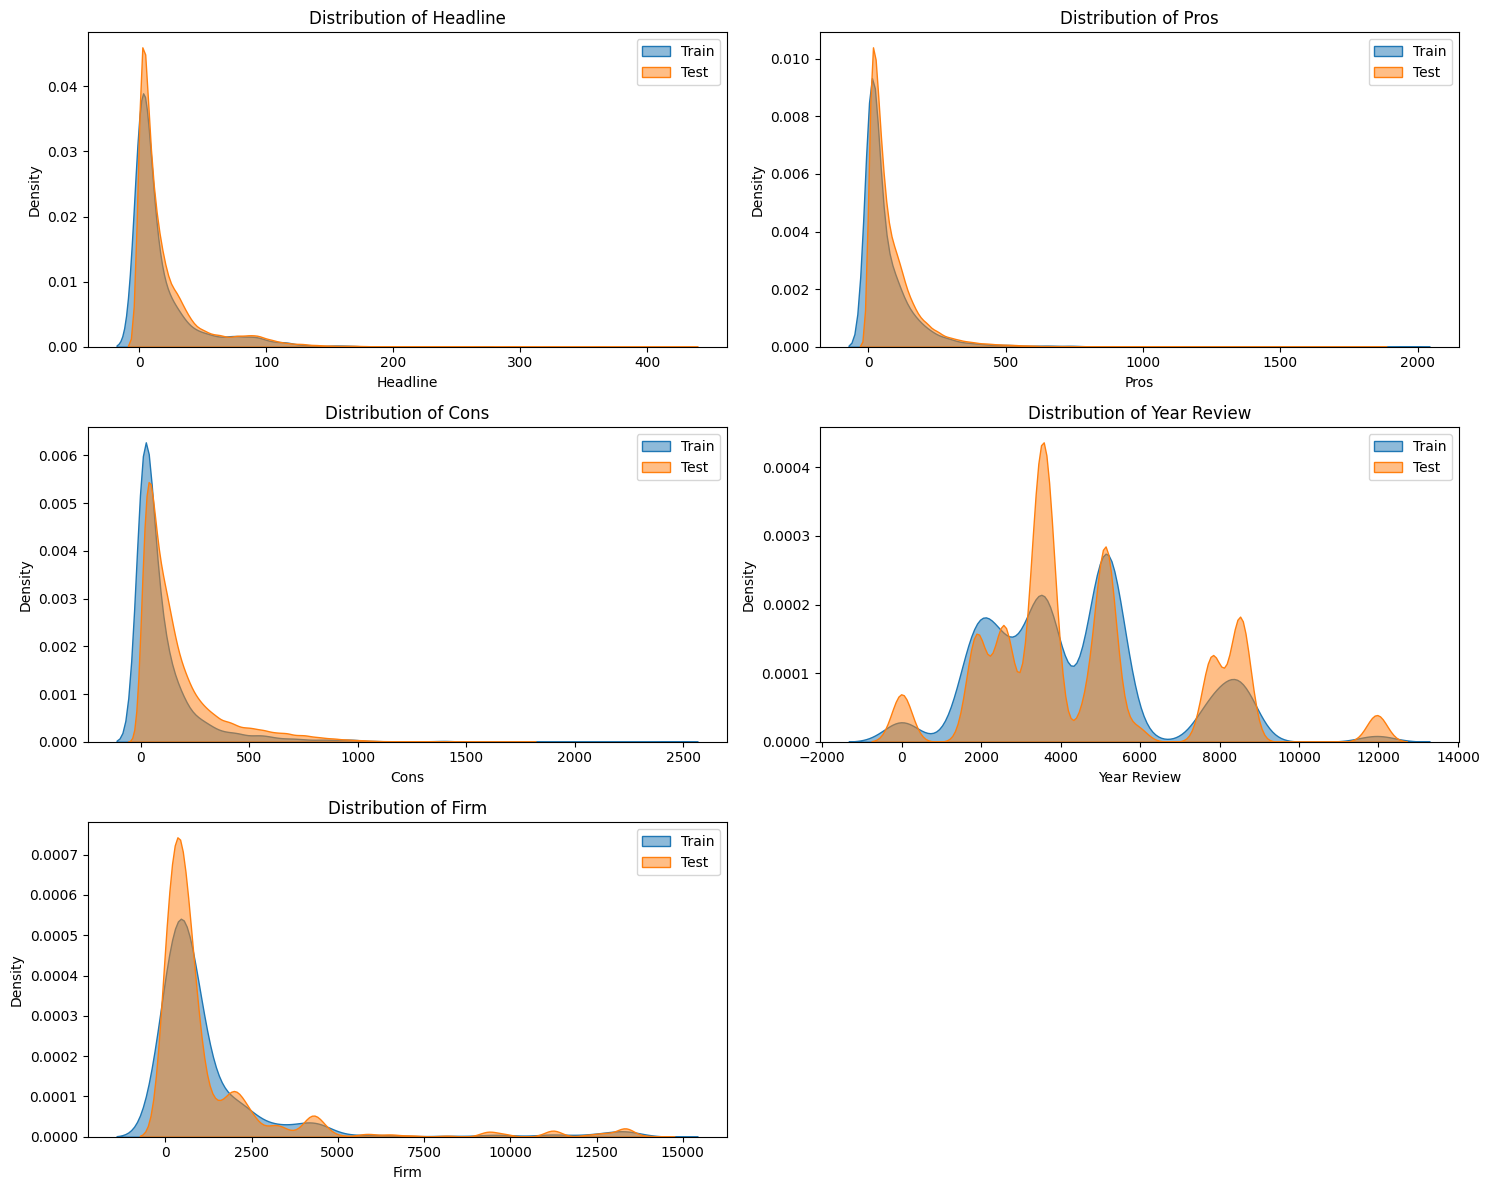

In [23]:


# Convert test data sequences to numerical summaries
headline_test_numeric = np.mean(X_test_headline_pad, axis=1)
pros_test_numeric = np.mean(X_test_pros_pad, axis=1)
cons_test_numeric = np.mean(X_test_cons_pad, axis=1)
year_test_numeric = np.mean(X_test_year_pad, axis=1)
firm_test_numeric = np.mean(X_test_firm_pad, axis=1)

# Create DataFrames for training and test data
train_features_df = pd.DataFrame({
    'Headline': headline_numeric,
    'Pros': pros_numeric,
    'Cons': cons_numeric,
    'Year Review': year_numeric,
    'Firm': firm_numeric
})

test_features_df = pd.DataFrame({
    'Headline': headline_test_numeric,
    'Pros': pros_test_numeric,
    'Cons': cons_test_numeric,
    'Year Review': year_test_numeric,
    'Firm': firm_test_numeric
})

# Plot distributions for each feature
feature_names = ['Headline', 'Pros', 'Cons', 'Year Review', 'Firm']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(feature_names, 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(train_features_df[feature], label='Train', fill=True, alpha=0.5)
    sns.kdeplot(test_features_df[feature], label='Test', fill=True, alpha=0.5)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step


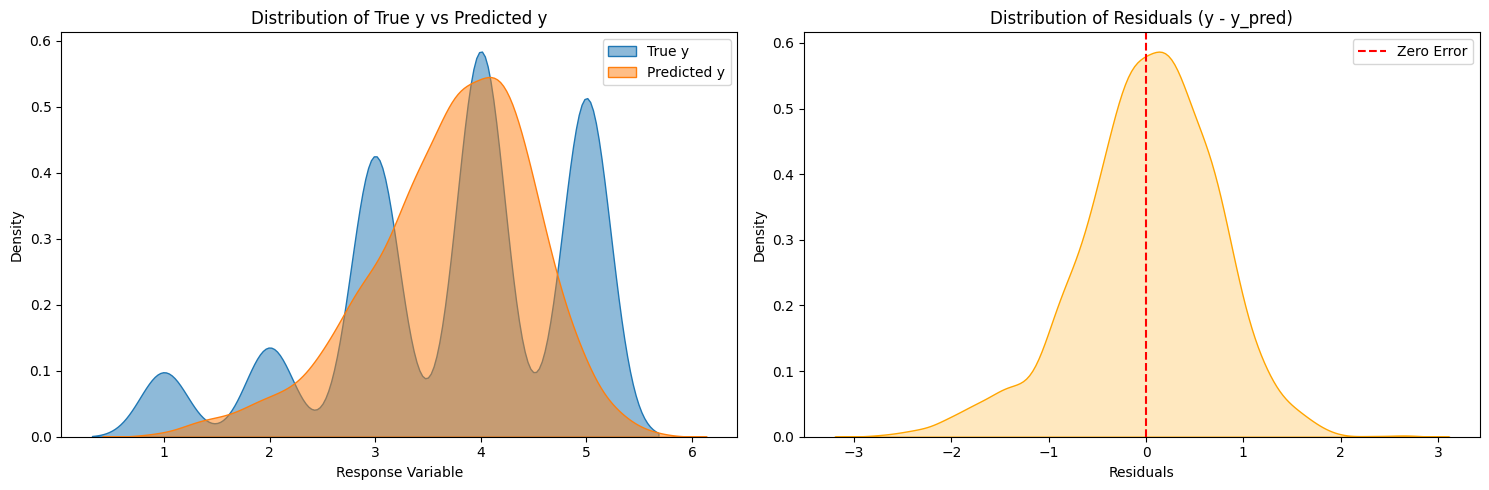

In [24]:
# Predict the response variable for the training data
y_train_pred = model.predict([X_train_headline_pad, X_train_pros_pad, X_train_cons_pad, X_train_year_pad, X_train_firm_pad])

# Calculate residuals (errors)
residuals = y_train - y_train_pred.flatten()

# Plot y vs. y_pred distribution
plt.figure(figsize=(15, 5))

# Plot the distribution of true y and predicted y
plt.subplot(1, 2, 1)
sns.kdeplot(y_train, label='True y', fill=True, alpha=0.5)
sns.kdeplot(y_train_pred.flatten(), label='Predicted y', fill=True, alpha=0.5)
plt.title('Distribution of True y vs Predicted y')
plt.xlabel('Response Variable')
plt.legend()

# Plot the distribution of residuals
plt.subplot(1, 2, 2)
sns.kdeplot(residuals, fill=True, color='orange')
plt.title('Distribution of Residuals (y - y_pred)')
plt.xlabel('Residuals')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.legend()

plt.tight_layout()
plt.show()


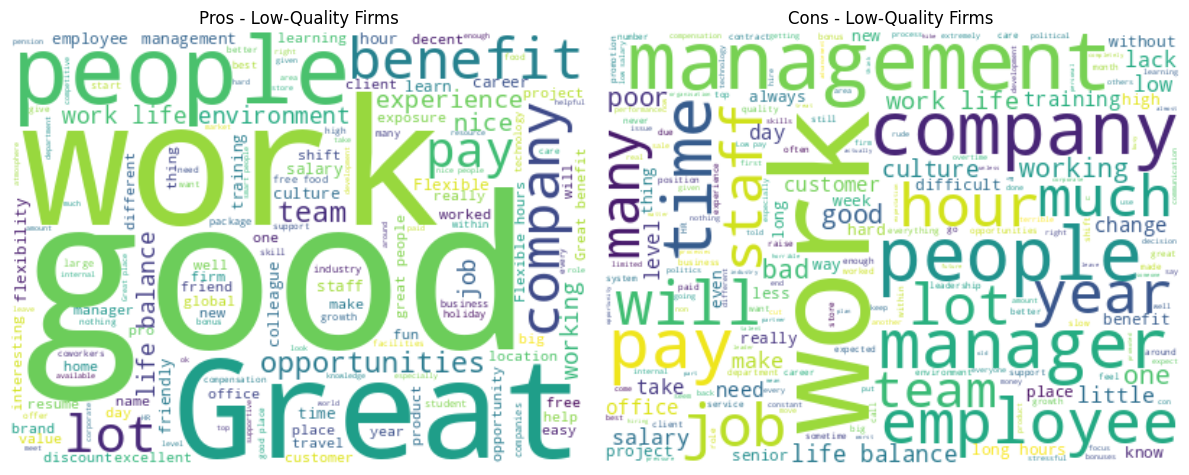

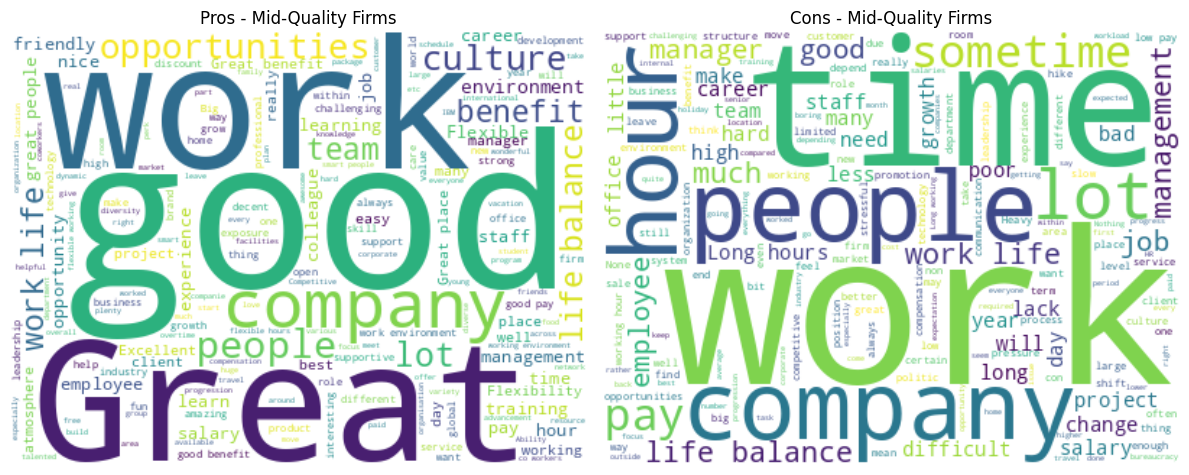

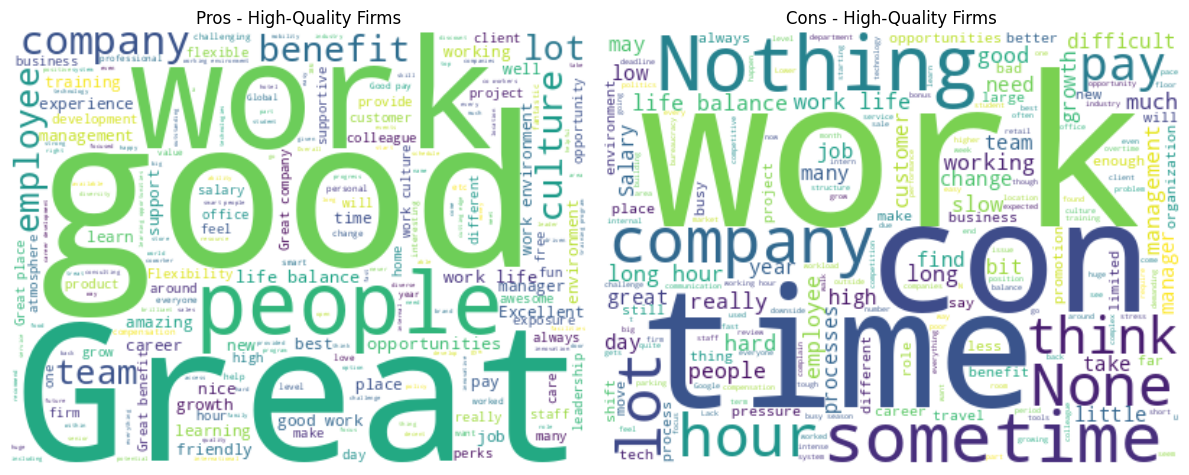

In [26]:
from collections import Counter
from wordcloud import WordCloud
# Segment firms based on average ratings
low_quality = train_data[train_data['rating'] <= 3.0]
mid_quality = train_data[(train_data['rating'] > 3.0) & (train_data['rating'] <= 4.0)]
high_quality = train_data[train_data['rating'] > 4.0]

# Function to generate and display word clouds for 'pros' and 'cons'
def plot_wordclouds(data, title):
    pros_text = ' '.join(data['pros'].dropna())
    cons_text = ' '.join(data['cons'].dropna())

    # Generate word clouds
    pros_wordcloud = WordCloud(width=400, height=300, background_color='white').generate(pros_text)
    cons_wordcloud = WordCloud(width=400, height=300, background_color='white').generate(cons_text)

    # Plot the word clouds
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(pros_wordcloud, interpolation='bilinear')
    plt.title(f'Pros - {title}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cons_wordcloud, interpolation='bilinear')
    plt.title(f'Cons - {title}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot word clouds for each segment
plot_wordclouds(low_quality, 'Low-Quality Firms')
plot_wordclouds(mid_quality, 'Mid-Quality Firms')
plot_wordclouds(high_quality, 'High-Quality Firms')


In [26]:
!pip install --upgrade tensorflow
!pip install --upgrade shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 772.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
